# Part I

In [1]:
# Library imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

###1.1.1 Solving the System of Bellman Equations

In [2]:
gamma=0.95 # Discount factor for future rewards
num_state=25 # Total number of states in 5x5 grid
grid=5 # Grid dimensions

#actions
actions={'up':(-1,0),'down':(1,0),'left':(0,-1),'right':(0,1)}

#special square
BLUE = 1     # Blue square at position (0,1) - gives reward +5, transitions to RED
GREEN = 4   # Green square at position (0,4) - gives reward +2.5, transitions to RED or YELLOW
RED = 17    # Red square at position (3,2)
YELLOW = 24  # Yellow square at position (4,4)


# Initialize coefficient matrix A and reward vector B for linear system A·V = B
A=np.zeros((num_state,num_state))  # Coefficient matrix (25x25)
B=np.zeros(num_state) # Reward vector (25x1)

for s in range(num_state):

  # Special handling for BLUE square
  if s==BLUE:
    A[s][s]=1 # Coefficient of V(blue)
    A[s][RED]=-gamma # Coefficient of V(red)
    B[s]=5 # Immediate reward
    # print(f"  State {s} (BLUE): V[{s}] - {gamma}*V[{RED}] = 5")

  # Special handling for GREEN square
  elif s==GREEN:
    A[s][s]=1 # Coefficient of V(green)
    A[s][RED]=-0.5*gamma # Coefficient of V(red) with 50% probability
    A[s][YELLOW]=-0.5*gamma # Coefficient of V(yellow) with 50% probability
    B[s]=2.5 # Immediate reward
    # print(f"  State {s} (GREEN): V[{s}] - 0.5*{gamma}*V[{RED}] - 0.5*{gamma}*V[{YELLOW}] = 2.5")


  # All other states
  else:
    # Convert linear state index to (row, col) coordinates
    row,col=divmod(s,grid)
    A[s][s] = 1 # Coefficient of current state V(s)

    # Considering all four actions with equal probability
    for shift in actions.values():
      r,c=shift
      new_row,new_col=row+r,col+c

      # Check if the action stays within grid boundaries
      if 0<=new_row<grid and 0<=new_col<grid:
        s_new=new_row*grid+new_col    # Convert back to linear index
        reward=0 # No immediate reward for normal transitions
      else:
        # Invalid move: hit boundary, stay in same state with penalty
        s_new=s
        reward=-0.5

      # Update coefficient matrix and reward vector
      # Each action has 0.25 probability under random policy
      A[s][s_new] -= 0.25*gamma # Subtract discounted future value coefficient
      B[s] += 0.25*reward # Add expected immediate reward

# Solve the linear system to find the value function
value= np.linalg.solve(A, B)

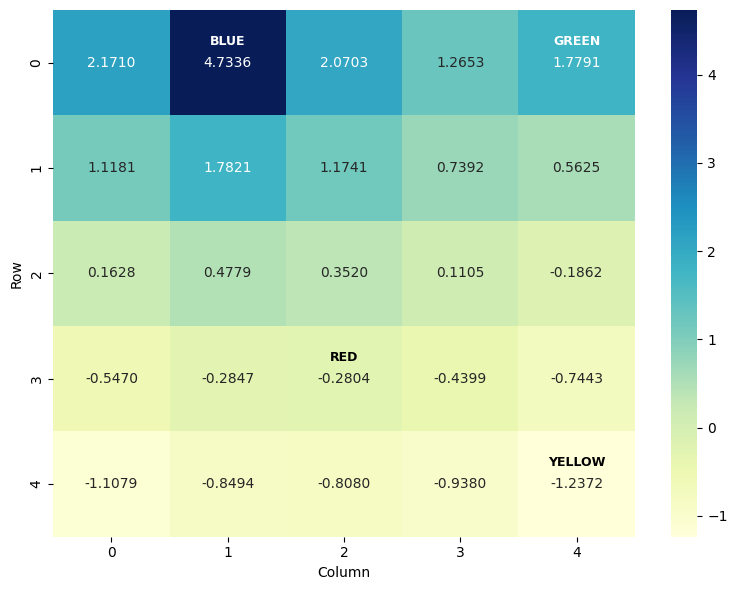

In [3]:
# Reshape for visualization
V_grid = value.reshape((grid, grid))

# Plotting labels
plt.figure(figsize=(8, 6))
sns.heatmap(V_grid, annot=True, fmt=".4f", cmap="YlGnBu", cbar=True)
# plt.title("Value Function (Bellman Equations) \nRandom Policy, γ=0.95",
#           fontsize=14, fontweight='bold')
plt.xlabel("Column")
plt.ylabel("Row")

# Add labels with offset
blue_row, blue_col = divmod(BLUE, grid)
green_row, green_col = divmod(GREEN, grid)
red_row, red_col = divmod(RED, grid)
yellow_row, yellow_col = divmod(YELLOW, grid)

plt.text(blue_col + 0.5, blue_row + 0.3, 'BLUE', ha='center', va='center',
         fontsize=9, fontweight='bold', color='white')
plt.text(green_col + 0.5, green_row + 0.3, 'GREEN', ha='center', va='center',
         fontsize=9, fontweight='bold', color='white')
plt.text(red_col + 0.5, red_row + 0.3, 'RED', ha='center', va='center',
         fontsize=9, fontweight='bold', color='black')
plt.text(yellow_col + 0.5, yellow_row + 0.3, 'YELLOW', ha='center', va='center',
         fontsize=9, fontweight='bold', color='black')

plt.tight_layout()
plt.show()

###1.1.2 Iterative Policy Evaluation

In [4]:
grid = 5 # Grid size (5x5)
num_state=25  # Total number of states (5x5 = 25)
gamma = 0.95 # Discount factor for future rewards
iteration = 1000    # Maximum number of iterations
theta = 1e-4   # Convergence threshold

# Special state definitions
blue = 1 # Blue square at position (0,1) - gives reward +5, transitions to RED
green = 4 # Green square at position (0,4) - gives reward +2.5, transitions to RED(50%) + YELLOW(50%)
red = 17 # Red square at position (3,2)
yellow = 24 # Yellow square at position (4,4)

# Initialize value function to zeros (initial estimate)
v = np.zeros(grid * grid)

# Define possible actions as (row_change, column_change)
actions = {'up': (-1, 0), 'down': (1, 0), 'left': (0, -1), 'right': (0, 1)}

# Track convergence for analysis
convergence_data = []

print("Starting iterative policy evaluation...")

for i in range(iteration):
    delta=0 # Track maximum change in value function this iteration
    v_new = v.copy()    # Copy current value function for updates

    for s in range(num_state):    # Loop through each state (0 to 24)
        row, col = divmod(s, grid)    # Convert linear state index to (row, col) coordinates

        # Handle BLUE square - when agent STARTS from blue
        if s == blue:
            v_new[s] = 5 + gamma * v[red]

        # Handle GREEN square - when agent STARTS from green
        elif s == green:
            v_new[s] = 2.5 + 0.5 * gamma * v[red] + 0.5 * gamma * v[yellow]

        # Handle Others
        else:
            total = 0  # Initialize expected value for this state

            # Consider all four actions with equal probability (0.25 each)
            for shift in actions.values():
                r, c = shift
                new_row, new_col = row + r, col + c

                if 0 <= new_row < grid and 0 <= new_col < grid:
                    # Valid move: transition to new state
                    s_new = new_row * grid + new_col

                    # Future value comes from where we land, but no special landing bonuses
                    total += 0.25 * (0 + gamma * v[s_new])

                else:
                    # Invalid move: hit boundary, stay in same state with penalty
                    reward = -0.5                           # Penalty for hitting grid boundary
                    total += 0.25 * (reward + gamma * v[s]) # Stay in current state

            v_new[s] = total  # assigning the total

        delta = max(delta, abs(v_new[s] - v[s]))    # Track largest value difference

    v = v_new.copy()     # Update value function with new values

    # Store convergence data for analysis
    convergence_data.append({
        'iteration': i + 1,
        'delta': delta,
        'max_value': np.max(v),
        'blue_value': v[blue]
    })

    # Print progress every 100 iterations
    if (i + 1) % 100 == 0:
        print(f"Iteration {i+1:3d}: delta = {delta:.6f}, max_value = {np.max(v):.3f}")

    # Check for convergence
    if delta < theta:
      print(f"Converged after {i+1} iterations.")
      print(f"Final delta: {delta:.6f}")
      break

else:
    print(f"\n  Reached maximum iterations ({iteration}) without convergence")

# Analysis section
max_value = np.max(v)
max_state = np.argmax(v)
max_row, max_col = divmod(max_state, grid)

print(f"Highest value: {max_value:.3f} at state {max_state} = position ({max_row}, {max_col})")

# Identify which special state it is
if max_state == blue:
    print("This is the BLUE square - expected due to highest immediate reward!")
elif max_state == green:
    print("This is the GREEN square")
elif max_state == red:
    print("This is the RED square")
elif max_state == yellow:
    print("This is the YELLOW square")
else:
    print("This is a normal state")

# Reshape 1D value array to 2D grid for visualization
V_grid = v.reshape((grid, grid))
print("Final Value Function (reshaped):")
print(np.round(V_grid, 2))

Starting iterative policy evaluation...
Converged after 82 iterations.
Final delta: 0.000096
Highest value: 4.735 at state 1 = position (0, 1)
This is the BLUE square - expected due to highest immediate reward!
Final Value Function (reshaped):
[[ 2.17  4.74  2.07  1.27  1.78]
 [ 1.12  1.78  1.18  0.74  0.56]
 [ 0.16  0.48  0.35  0.11 -0.18]
 [-0.55 -0.28 -0.28 -0.44 -0.74]
 [-1.11 -0.85 -0.81 -0.94 -1.24]]


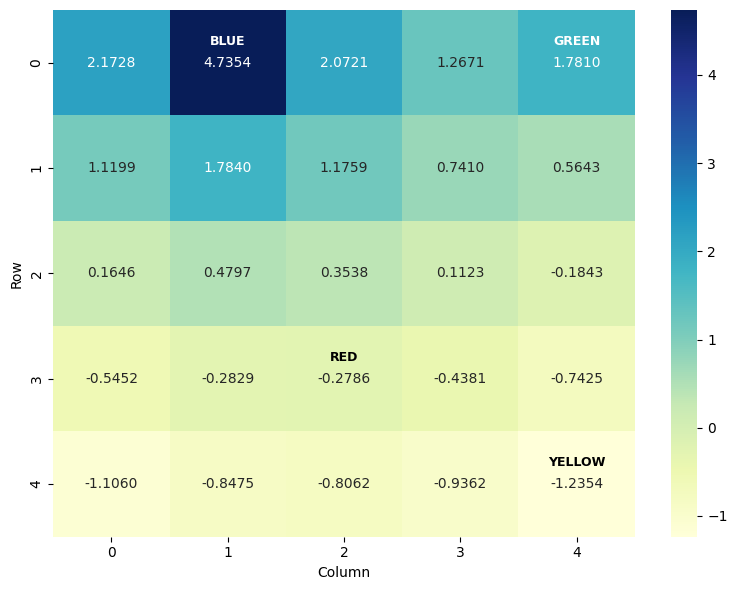

In [5]:
# Generate heatmap with the lables
plt.figure(figsize=(8, 6))
sns.heatmap(V_grid, annot=True, fmt=".4f", cmap="YlGnBu", cbar=True)
# plt.title("Value Function (Iterative Policy Evaluation - LABELED)\nRandom Policy, γ=0.95",
#           fontsize=14, fontweight='bold')
plt.xlabel("Column")
plt.ylabel("Row")

# Calculate exact positions for labels
blue_row, blue_col = divmod(blue, grid)      # (0, 1)
green_row, green_col = divmod(green, grid)   # (0, 4)
red_row, red_col = divmod(red, grid)         # (3, 2)
yellow_row, yellow_col = divmod(yellow, grid) # (4, 4)

# Place labels with vertical offset to avoid overlapping with numbers
plt.text(blue_col + 0.5, blue_row + 0.3, 'BLUE', ha='center', va='center',
         fontsize=9, fontweight='bold', color='white')
plt.text(green_col + 0.5, green_row + 0.3, 'GREEN', ha='center', va='center',
         fontsize=9, fontweight='bold', color='white')
plt.text(red_col + 0.5, red_row + 0.3, 'RED', ha='center', va='center',
         fontsize=9, fontweight='bold', color='black')
plt.text(yellow_col + 0.5, yellow_row + 0.3, 'YELLOW', ha='center', va='center',
         fontsize=9, fontweight='bold', color='black')

plt.tight_layout()
plt.show()


Creating Side-by-Side Method Comparison


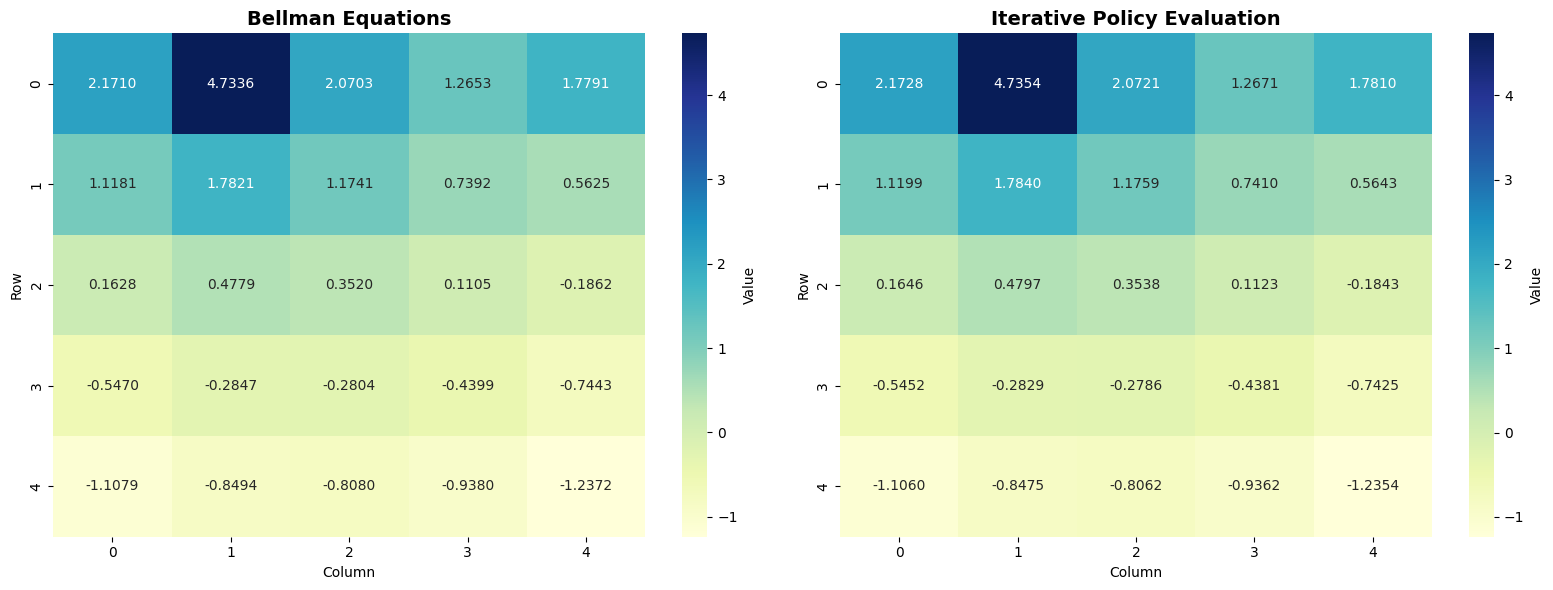

In [6]:
value_bellman = value  # From your Bellman equations code
value_iterative = v    # From your iterative policy evaluation code

# Reshape to grids
V_grid_bellman = value_bellman.reshape((grid, grid))
V_grid_iterative = value_iterative.reshape((grid, grid))

print("Creating Side-by-Side Method Comparison")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left: Bellman Equations with 4 decimal places
sns.heatmap(V_grid_bellman, annot=True, fmt=".4f", cmap="YlGnBu",
            cbar_kws={'label': 'Value'}, ax=axes[0])
axes[0].set_title("Bellman Equations", fontsize=14, fontweight='bold')
axes[0].set_xlabel("Column")
axes[0].set_ylabel("Row")

# Right: Iterative Policy Evaluation with 4 decimal places
sns.heatmap(V_grid_iterative, annot=True, fmt=".4f", cmap="YlGnBu",
            cbar_kws={'label': 'Value'}, ax=axes[1])
axes[1].set_title("Iterative Policy Evaluation", fontsize=14, fontweight='bold')
axes[1].set_xlabel("Column")
axes[1].set_ylabel("Row")

# plt.suptitle("Value Function Comparison: Both Methods", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


Creating Special State Value Comparison...


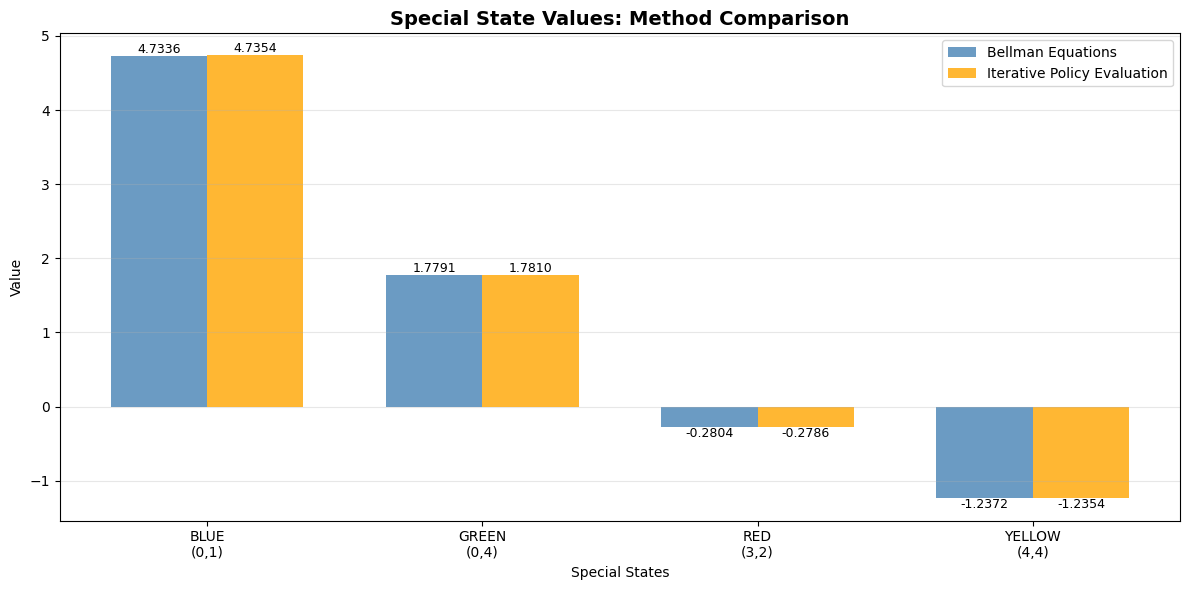

In [7]:
print("Creating Special State Value Comparison...")

# Extract actual values from your results
states = ['BLUE\n(0,1)', 'GREEN\n(0,4)', 'RED\n(3,2)', 'YELLOW\n(4,4)']
state_indices = [blue, green, red, yellow]

bellman_values = [value_bellman[idx] for idx in state_indices]
iterative_values = [value_iterative[idx] for idx in state_indices]

x = np.arange(len(states))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, bellman_values, width, label='Bellman Equations',
               alpha=0.8, color='steelblue')
bars2 = ax.bar(x + width/2, iterative_values, width, label='Iterative Policy Evaluation',
               alpha=0.8, color='orange')

ax.set_xlabel('Special States')
ax.set_ylabel('Value')
ax.set_title('Special State Values: Method Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(states)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars with 4 decimal places
for bar in bars1:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.4f}', ha='center', va='bottom' if height > 0 else 'top', fontsize=9)

for bar in bars2:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.4f}', ha='center', va='bottom' if height > 0 else 'top', fontsize=9)

plt.tight_layout()
plt.show()

## 1.2 Optimal Policy

### 1.2.1 Explicitly Solving the Bellman Optimality Equation

Starting Value Iteration for Bellman Optimality Equation...
Iteration 100: delta = 0.031161, max_value = 21.9716
Iteration 200: delta = 0.000184, max_value = 22.1017

 Converged after 212 iterations!
Final delta: 0.000100

Highest value: 22.102111 at state 1 = position (0, 1)
This is the BLUE square - expected due to highest immediate reward
Final Value Function (reshaped):
[[21.   22.1  21.   19.95 18.38]
 [19.95 21.   19.95 18.95 18.  ]
 [18.95 19.95 18.95 18.   17.1 ]
 [18.   18.95 18.   17.1  16.25]
 [17.1  18.   17.1  16.25 15.43]]


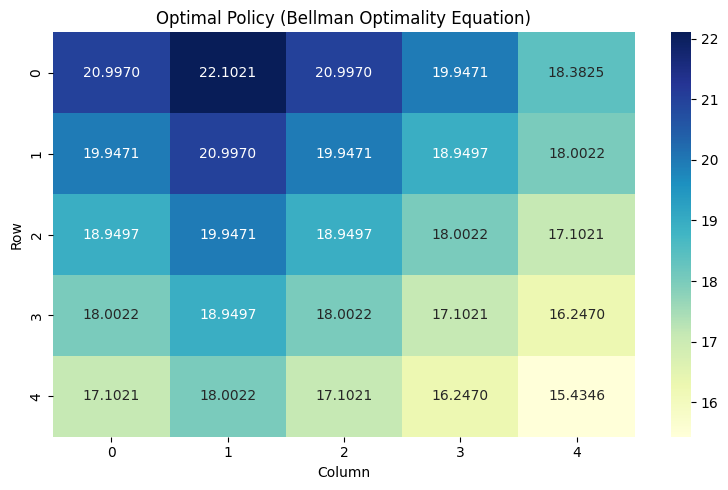

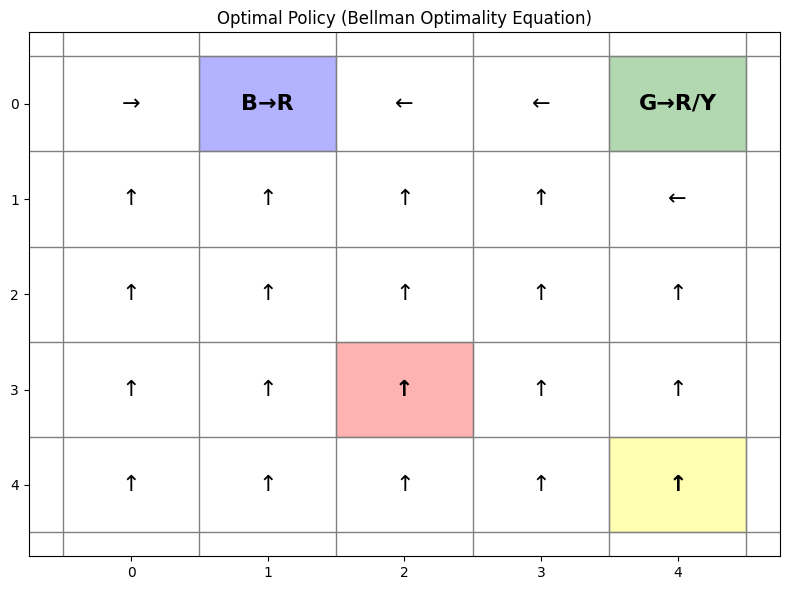

In [8]:
grid = 5 # Grid size
gamma = 0.95 # Discount factor for future rewards
iteration = 1000 # Maximum number of iterations for convergence
theta = 1e-4 # Convergence threshold


blue = 1 # Blue square at position (0,1): immediate reward +5 → transitions to RED
green = 4 # Green square at position (0,4): immediate reward +2.5 → transitions to RED or YELLOW
red = 17 # Red square at position (3,2)
yellow = 24 # Yellow square at position (4,4)

# Initialize data structures
v = np.zeros(grid * grid) # Value function: V(s) for all states (initially all zeros)
policy = np.full(grid * grid, '', dtype=object)  # Policy storage: π(s) for all states

#actions
actions = {'up': (-1, 0), 'down': (1, 0), 'left': (0, -1), 'right': (0, 1)}

# Arrow symbols
arrow_map = {'up': '↑', 'down': '↓', 'left': '←', 'right': '→'}

print("Starting Value Iteration for Bellman Optimality Equation...")

for i in range(iteration):
    delta=0 #tracking maximum change in value function this iteration
    v_new = v.copy() # Create copy of current value function for synchronous updates

    for s in range(grid * grid):
        row, col = divmod(s, grid) # Convert linear state index to (row, column) coordinates
        # Handle BLUE square
        if s == blue:
            v_new[s] = 5 + gamma * v[red]
        #handling green square
        elif s == green:
            v_new[s] = 2.5 + 0.5 * gamma * v[red] + 0.5 * gamma * v[yellow]
        else:
            action_values = []  # Store value for each possible action

            # Evaluate each possible action from current state
            for action_name, (dr, dc) in actions.items():
                new_row, new_col = row + dr, col + dc # Calculate resulting position

                # Check if action results in valid grid position
                if 0 <= new_row < grid and 0 <= new_col < grid:
                    # VALID MOVE: Transition to new state
                    s_new = new_row * grid + new_col # Convert position back to linear index
                    immediate_reward = 0  # No reward for normal transitions
                    # Calculate action value using Bellman equation
                    action_value = immediate_reward + gamma * v[s_new]
                else:
                    immediate_reward = -0.5   # Penalty for hitting grid boundary
                    # Agent stays in current state when hitting boundary
                    action_value = immediate_reward + gamma * v[s]  # v[s]

                action_values.append(action_value) # Store this action's value

            # Bellman Optimality: take maximum over all actions
            v_new[s] = max(action_values)

        # Track maximum change across all states for convergence checking
        delta = max(delta, abs(v_new[s] - v[s]))

    v = v_new.copy() # Update value function with new values

    # Progress reporting
    if (i + 1) % 100 == 0:
        print(f"Iteration {i+1}: delta = {delta:.6f}, max_value = {np.max(v):.4f}")

    # Check for convergence: stop if maximum change is below threshold
    if delta < theta:
        print(f"\n Converged after {i+1} iterations!")
        print(f"Final delta: {delta:.6f}")
        break
else:
    # This executes if loop completes without breaking (no convergence)
    print(f"\n Reached maximum iterations without convergence")

# Analysis section
max_value = np.max(v)
max_state = np.argmax(v)
max_row, max_col = divmod(max_state, grid)

print(f"\nHighest value: {max_value:.6f} at state {max_state} = position ({max_row}, {max_col})")

# Identify which special state has highest value
if max_state == blue:
    print("This is the BLUE square - expected due to highest immediate reward")
elif max_state == green:
    print("This is the GREEN square")
elif max_state == red:
    print("This is the RED square")
elif max_state == yellow:
    print("This is the YELLOW square")
else:
    print("This is a normal state")

# Extract the Policy
for s in range(grid * grid):
    row, col = divmod(s, grid) # Convert state index to coordinates

    if s == blue:
        policy[s] = 'B→R'  # Blue square has deterministic transition to red
    elif s == green:
        policy[s] = 'G→R/Y'  # Green square has probabilistic transition to red/yellow
    else:
        best_value = -np.inf # Initialize with negative infinity
        best_action = None # Will store the optimal action

        # Evaluate each action to find the one with maximum value
        for action_name, (dr, dc) in actions.items():
            new_row, new_col = row + dr, col + dc

            # Check if action results in valid position
            if 0 <= new_row < grid and 0 <= new_col < grid:
                # Valid move to new state
                s_new = new_row * grid + new_col
                immediate_reward = 0  # Include immediate reward
                action_value = immediate_reward + gamma * v[s_new]
            else:
                # Boundary collision: stay in current state with penalty
                immediate_reward = -0.5
                action_value = immediate_reward + gamma * v[s]  # v[s]

            # Update best action if this action has higher value
            if action_value > best_value:
                best_value = action_value
                best_action = action_name

        policy[s] = best_action # Store optimal action for this state


# Reshape value function from 1D array to 2D grid for visualization
V_grid = v.reshape((grid, grid))

# Create policy grid with arrow symbols for visualization
policy_grid = np.array([arrow_map.get(p, p) if p not in ['B→R', 'G→R/Y'] else p for p in policy]).reshape((grid, grid))
print("Final Value Function (reshaped):")
print(np.round(V_grid, 2))

# Create heatmap visualization of the value function
plt.figure(figsize=(8, 5))
sns.heatmap(V_grid, annot=True, fmt=".4f", cmap="YlGnBu", cbar=True)
plt.title("Optimal Policy (Bellman Optimality Equation)")
plt.xlabel("Column")
plt.ylabel("Row")
plt.tight_layout()
plt.show()

# Create a grid plot for the optimal policy
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_xticks(np.arange(grid))
ax.set_yticks(np.arange(grid))
ax.set_xticklabels(np.arange(grid))
ax.set_yticklabels(np.arange(grid))
ax.invert_yaxis()

# Define colors for special states
colors = {
    blue: 'blue',    # Blue square at (0,1)
    green: 'green',  # Green square at (0,4)
    red: 'red',      # Red square at (3,2)
    yellow: 'yellow' # Yellow square at (4,4)
}

for i in range(grid):  # Iterate through rows (0 to 4)
    for j in range(grid):  # Iterate through columns (0 to 4)
        state_index = i * grid + j  # Convert (row, col) to linear state index

        # Check if this is a special colored state
        if state_index in colors:
            # Add colored rectangle for special states
            rect = plt.Rectangle((j-0.5, i-0.5), 1, 1,
                               facecolor=colors[state_index],
                               alpha=0.3, edgecolor='black')
            ax.add_patch(rect)

        # Add policy text (arrows or special transitions)
        ax.text(j, i, policy_grid[i, j], ha='center', va='center', fontsize=16,
                weight='bold' if state_index in colors else 'normal')

# Draw grid lines
for i in range(grid + 1):
    ax.axhline(i - 0.5, color='gray', linewidth=1)
    ax.axvline(i - 0.5, color='gray', linewidth=1)

ax.set_title("Optimal Policy (Bellman Optimality Equation)")
plt.tight_layout()
plt.show()

### 1.2.2 Using Policy Iteration with Iterative Policy Evaluation

Initial policy set for 25 states
Special states: BLUE=B→R, GREEN=G→R/Y


--- Iteration 1 ---
Policy Evaluation...
  Policy evaluation converged in 168 iterations
  Policy changes: 19 states

--- Iteration 2 ---
Policy Evaluation...
  Policy evaluation converged in 4 iterations
  Policy changes: 13 states

--- Iteration 3 ---
Policy Evaluation...
  Policy evaluation converged in 209 iterations
  Policy changes: 5 states

--- Iteration 4 ---
Policy Evaluation...
  Policy evaluation converged in 3 iterations
  Policy changes: 3 states

--- Iteration 5 ---
Policy Evaluation...
  Policy evaluation converged in 1 iterations
  Policy changes: 0 states

 Policy Iteration converged after 5 iterations!

=== FINAL RESULTS ===
Highest value: 22.102192 at state 1 = position (0, 1)
This is the BLUE square - expected due to highest immediate reward
Total policy iteration cycles: 5
Final value function:
[[20.997  22.1022 20.997  19.9472 18.3826]
 [19.9472 20.997  19.9472 18.9498 18.0023]
 [18.9498 19.

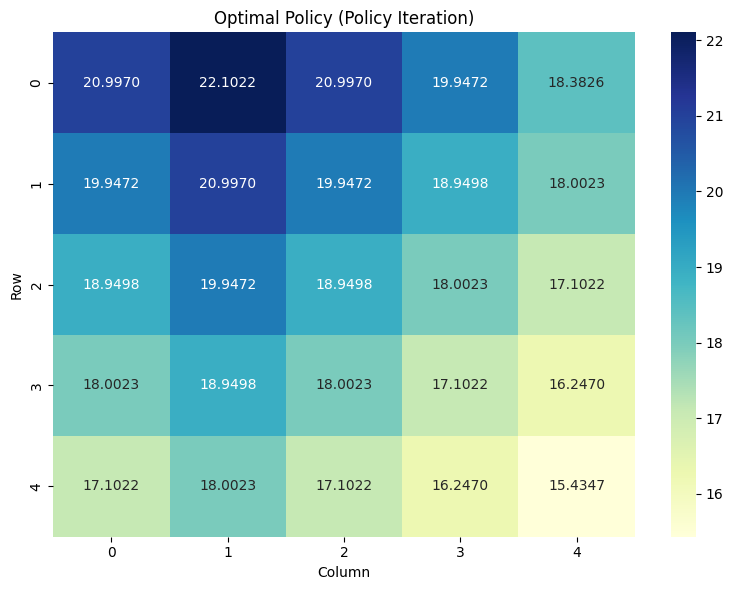

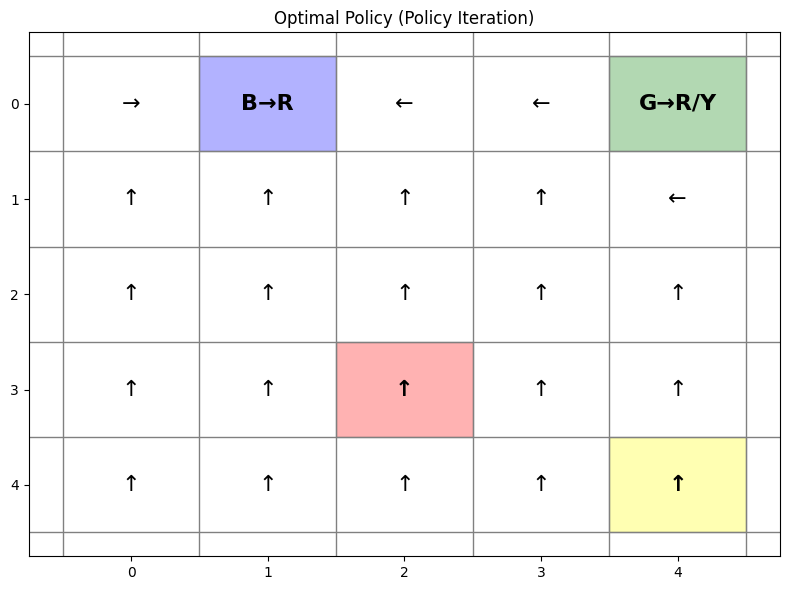

In [9]:
grid = 5 # Grid size: 5x5
gamma = 0.95 # Discount factor for future rewards
theta = 1e-4 # Convergence threshold for policy evaluation

blue = 1 # Blue square at position (0,1): immediate reward +5 → transitions to RED
green = 4  # Green square at position (0,4): immediate reward +2.5 → transitions to RED or YELLOW
red = 17 # Red square at position (3,2): normal state with standard transitions
yellow = 24 # Yellow square at position (4,4): normal state with standard transitions

# Initialize data structures
n_states = grid * grid  # Total number of states in the gridworld
v = np.zeros(n_states) # Value function for all states (initially all zeros)

# Action definitions: each action represented as (row_change, column_change)
actions_map = ['up', 'down', 'left', 'right']  # List of available actions
actions = {'up': (-1, 0), 'down': (1, 0), 'left': (0, -1), 'right': (0, 1)}
arrow_map = {'up': '↑', 'down': '↓', 'left': '←', 'right': '→'} # Arrow symbols for policy visualization


# Function to calculate Q-value for a given state-action
def get_q_value(s, a, v):
    row, col = divmod(s, grid) # Convert linear state index to (row, col)

    #Handling the blue state
    if s == blue:
        return 5 + gamma * v[red]
    #Handling the green state
    elif s == green:
        return 2.5 + 0.5 * gamma * v[red] + 0.5 * gamma * v[yellow]

    # Normal states: action-dependent transitions
    dr, dc = actions[a] # Get movement deltas for action a
    new_row, new_col = row + dr, col + dc # Calculate new position

    # Check if resulting position is within grid boundaries
    if 0 <= new_row < grid and 0 <= new_col < grid:
        # Agent successfully moves to new state
        s_new = new_row * grid + new_col # Convert new position to linear index
        immediate_reward = 0  # No reward for normal transitions
        return immediate_reward + gamma * v[s_new]
    else:
        # Boundary collision: stay in current state with penalty
        immediate_reward = -0.5 # Penalty for hitting boundary
        return immediate_reward + gamma * v[s]

# Proper initialization of policy
np.random.seed(42)  # For reproducibility
policy = np.random.choice(actions_map, size=n_states)  # Random initial policy

# Set special states appropriately
policy[blue] = 'B→R' # Blue square has fixed transition to red
policy[green] = 'G→R/Y' # Green square has probabilistic transition

print(f"Initial policy set for {n_states} states")
print(f"Special states: BLUE={policy[blue]}, GREEN={policy[green]}")
print()

# Policy Iteration Variables
iteration = 0 # Track number of policy iteration cycles
max_iterations = 100  # Prevent infinite loops

# Policy Iteration Loop
while iteration < max_iterations:
    print(f"\n--- Iteration {iteration + 1} ---")
    # Policy Evaluation
    print("Policy Evaluation...")
    eval_iterations = 0  # Track policy evaluation iterations

    while eval_iterations < 1000:  # Prevent infinite loops in evaluation
        delta = 0 # Track maximum value function change
        v_new = v.copy() # Create copy for synchronous updates

        # Update value function for each state under current policy
        for s in range(n_states):
            # Proper policy evaluation for all states
            if s == blue:
                # Blue square: deterministic transition
                v_new[s] = 5 + gamma * v[red]
            elif s == green:
                # Green square: probabilistic transition
                v_new[s] = 2.5 + 0.5 * gamma * v[red] + 0.5 * gamma * v[yellow]
            else:
                # Normal states: follow current policy
                current_action = policy[s]
                if current_action in actions_map:  # Valid action
                    v_new[s] = get_q_value(s, current_action, v)
                else:
                    # Fallback for invalid policy entries
                    q_values = [get_q_value(s, a, v) for a in actions_map]
                    v_new[s] = max(q_values)

            # Track maximum change for convergence checking
            delta = max(delta, abs(v_new[s] - v[s]))

        # Update value function (synchronous update)
        v = v_new.copy()
        eval_iterations += 1

        if delta < theta:
            print(f"  Policy evaluation converged in {eval_iterations} iterations")
            break

    # Policy Improvement : Find better policy
    stable = True  # Flag to track if policy changed
    changes = 0  # Count number of policy changes

    # Update policy for each state to be greedy with respect to V^π
    for s in range(n_states):
        # Special states keep their special policies
        if s == blue:
            policy[s] = 'B→R' # Blue square always transitions to red
            continue
        elif s == green:
            policy[s] = 'G→R/Y'  # Green square has probabilistic transition
            continue

        # Normal states: find best action
        old_action = policy[s] # Store current action for comparison
        q_values = [get_q_value(s, a, v) for a in actions_map] # Calculate Q-values for all possible actions

        # Select action with highest Q-value (greedy policy)
        best_action = actions_map[np.argmax(q_values)]
        policy[s] = best_action

        # Check if policy changed for this state
        if best_action != old_action:
            stable = False
            changes += 1

    print(f"  Policy changes: {changes} states")

    # Increment outer iteration counter
    iteration += 1

    # Policy Iteration converges when policy becomes stable (no changes)
    if stable:
        print(f"\n Policy Iteration converged after {iteration} iterations!")
        break
else:
    # This executes if maximum iterations reached without convergence
    print(f"\n Reached maximum iterations ({max_iterations})")

# Analysis section
max_value = np.max(v)
max_state = np.argmax(v)
max_row, max_col = divmod(max_state, grid)

print(f"\n=== FINAL RESULTS ===")
print(f"Highest value: {max_value:.6f} at state {max_state} = position ({max_row}, {max_col})")

if max_state == blue:
    print("This is the BLUE square - expected due to highest immediate reward")
elif max_state == green:
    print("This is the GREEN square")
elif max_state == red:
    print("This is the RED square")
elif max_state == yellow:
    print("This is the YELLOW square")
else:
    print("This is a normal state")

print(f"Total policy iteration cycles: {iteration}")
print(f"Final value function:")

V_grid = v.reshape((grid, grid))
print(np.round(V_grid, 4))

# Reshape value function from 1D array to 2D grid for visualization
policy_arrows = np.array([
    arrow_map.get(p, p) if p in arrow_map else p for p in policy
]).reshape((grid, grid))


# Display value function
plt.figure(figsize=(8, 6))
sns.heatmap(V_grid, annot=True, fmt=".4f", cmap="YlGnBu", cbar=True)
plt.title("Optimal Policy (Policy Iteration)")
plt.xlabel("Column")
plt.ylabel("Row")
ax.invert_yaxis()
plt.tight_layout()
plt.show()

# Display policy arrows with colored cells
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_xticks(np.arange(grid))
ax.set_yticks(np.arange(grid))
ax.set_xticklabels(np.arange(grid))
ax.set_yticklabels(np.arange(grid))
ax.invert_yaxis()

# Define colors for special states
colors = {
    blue: 'blue',    # Blue square at (0,1)
    green: 'green',  # Green square at (0,4)
    red: 'red',      # Red square at (3,2)
    yellow: 'yellow' # Yellow square at (4,4)
}

for i in range(grid):
    for j in range(grid):
        state_index = i * grid + j  # Convert (row, col) to linear state index

        # Check if this is a special colored state
        if state_index in colors:
            # Add colored rectangle for special states
            rect = plt.Rectangle((j-0.5, i-0.5), 1, 1,
                               facecolor=colors[state_index],
                               alpha=0.3, edgecolor='black')
            ax.add_patch(rect)

        # Add policy text (arrows or special transitions)
        ax.text(j, i, policy_arrows[i, j], ha='center', va='center', fontsize=16,
                weight='bold' if state_index in colors else 'normal')

for i in range(grid + 1):
    ax.axhline(i - 0.5, color='gray', linewidth=1)
    ax.axvline(i - 0.5, color='gray', linewidth=1)

ax.set_title("Optimal Policy (Policy Iteration)")
plt.tight_layout()
plt.show()



##(2.3) Policy Improvement with Value Iteration

Policy improvement with value iteration...

Step 1: Create Initial Policy
Initial policy created with random actions for normal states
Special states: BLUE=B→R, GREEN=G→R/Y

Step 2: Evaluate Initial Policy
  Policy evaluation converged in 168 iterations
Initial policy max value: 5.000000

Step 3: Run Value Iteration to Find V*
Phase A: True Value Iteration (max operator)
  Value iteration converged in 212 iterations

Step 4: Extract Optimal Policy from V* (Policy Improvement)
Phase B: Policy Improvement (greedy policy)
  Policy changes: 18 out of 23 normal states

Step 5: Policy Improvement Analysis
Value function improvement: 17.102111
Improvement percentage: 342.04%

 Final Results:
Highest value: 22.102111 at state 1 = position (0, 1)
This is the BLUE square - expected due to highest immediate reward


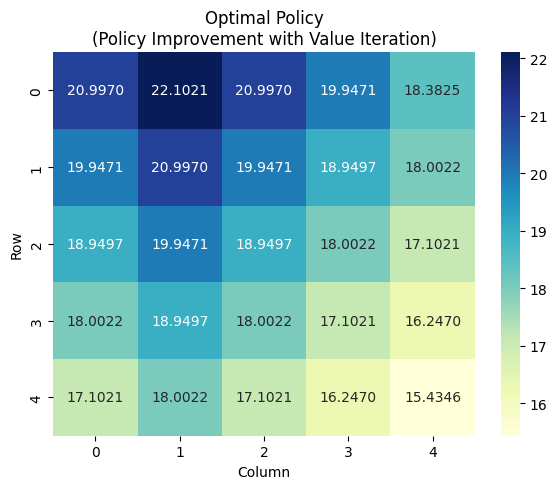

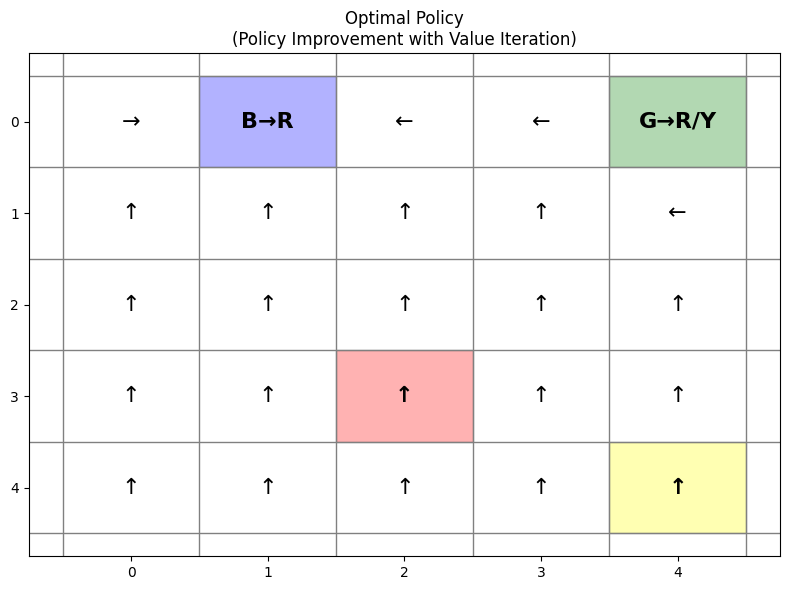

In [10]:
# Gridworld settings
grid = 5 # Grid size: 5x5
gamma = 0.95 # Discount factor for future rewards
theta = 1e-4  # Convergence threshold

# Special squares
blue = 1 # Blue square at position (0,1): immediate reward +5 → transitions to RED
green = 4 # Green square at position (0,4): immediate reward +2.5 → transitions to RED(50%) or YELLOW(50%)
red = 17 # Red square at position (3,2): normal state with standard transitions
yellow = 24 # Yellow square at position (4,4): normal state with standard transitions

n_states = grid * grid # Total number of states in the gridworld
actions_map = ['up', 'down', 'left', 'right'] # List of available actions

# Action definitions: each action represented as (row_change, column_change)
actions = {'up': (-1, 0), 'down': (1, 0), 'left': (0, -1), 'right': (0, 1)}

# Arrow symbols for policy visualization
arrow_map = {'up': '↑', 'down': '↓', 'left': '←', 'right': '→'}

print("Policy improvement with value iteration...")

# Helper: Q-value computation
def get_q_value(s, a, v):
    row, col = divmod(s, grid)  # Convert linear state index to (row, col) coordinates

    # Special states
    if s == blue:
        return 5 + gamma * v[red]
    elif s == green:
        return 2.5 + 0.5 * gamma * v[red] + 0.5 * gamma * v[yellow]

    # Normal states: action-dependent transitions
    dr, dc = actions[a] # Get movement deltas for action a
    new_row, new_col = row + dr, col + dc # Calculate new position after taking action


    # Check if resulting position is within grid boundaries
    if 0 <= new_row < grid and 0 <= new_col < grid:
        # Valid move: agent successfully transitions to new state
        s_new = new_row * grid + new_col # Convert new position back to linear index
        immediate_reward = 0  # No reward for normal transitions
        return immediate_reward + gamma * v[s_new]
    else:
        # Boundary collision: agent hits grid edge and stays in current state
        immediate_reward = -0.5 # Penalty for hitting boundary
        return immediate_reward + gamma * v[s] # Stay in current state with penalty

def evaluate_policy(policy, max_iterations=1000):
    """Evaluate a given policy to get its value function"""
    v = np.zeros(n_states) # Initialize value function to zeros

    for iteration in range(max_iterations):
        delta = 0 # Track maximum change in value function this iteration
        v_new = v.copy() # Update value function for each state following the given policy

        for s in range(n_states):
            if s == blue:
                # Blue square: deterministic transition regardless of policy
                v_new[s] = 5 + gamma * v[red]
            elif s == green:
                # Green square: probabilistic transition regardless of policy
                v_new[s] = 2.5 + 0.5 * gamma * v[red] + 0.5 * gamma * v[yellow]
            else:
                # Normal states: follow the current policy
                action = policy[s] # Get action prescribed by policy for this state
                v_new[s] = get_q_value(s, action, v) # Calculate value following policy

            # Track maximum change for convergence checking
            delta = max(delta, abs(v_new[s] - v[s]))

        v = v_new.copy() # Update value function (synchronous update)

        if delta < theta: # Check for convergence
            print(f"  Policy evaluation converged in {iteration + 1} iterations")
            return v


    print(f"  Policy evaluation reached max iterations ({max_iterations})")
    return v

# Step 1: Initialize with Initial Policy
print("\nStep 1: Create Initial Policy")
np.random.seed(42) # Set random seed for reproducibility

# Create random initial policy: each normal state gets a random action
initial_policy = np.random.choice(actions_map, size=n_states)

# Set special states with shorter labels to avoid display truncation
initial_policy[blue] = 'B→R'  # Blue transitions to Red
initial_policy[green] = 'G→R/Y' # Green transitions to Red or Yellow

print(f"Initial policy created with random actions for normal states")
print(f"Special states: BLUE={initial_policy[blue]}, GREEN={initial_policy[green]}")


# Step 2: Evaluate Initial Policy (optional - for comparison)
print("\nStep 2: Evaluate Initial Policy")

# Evaluate the initial policy to see how good it is
v_initial = evaluate_policy(initial_policy)
initial_max_value = np.max(v_initial)
print(f"Initial policy max value: {initial_max_value:.6f}")

# Step 3: Run Value Iteration to Find Optimal Value Function
print("\nStep 3: Run Value Iteration to Find V*")
print("Phase A: True Value Iteration (max operator)")

# Initialize value function
# Initialize value function for value iteration
v = np.zeros(n_states) # Start with all zeros
value_iteration = 0  # Track number of iterations


# Run Value Iteration until convergence
while value_iteration < 1000: # Prevent infinite loops
    delta = 0 # Track maximum value function change this iteration
    v_new = v.copy()  # Create copy for synchronous updates

    # Update value function for each state using Bellman optimality equation
    for s in range(n_states):
        # Special states
        if s == blue:
            # Blue square: deterministic high-reward transition
            v_new[s] = 5 + gamma * v[red]
        elif s == green:
            # Green square: probabilistic moderate-reward transition
            v_new[s] = 2.5 + 0.5 * gamma * v[red] + 0.5 * gamma * v[yellow]
        else:
            # Normal states: apply Bellman optimality equation
            q_values = [get_q_value(s, a, v) for a in actions_map]
            v_new[s] = max(q_values)

        # Track maximum change across all states for convergence checking
        delta = max(delta, abs(v_new[s] - v[s]))

    # Update value function (synchronous update)
    v = v_new.copy()
    value_iteration += 1

    # Progress reporting every 50 iterations
    if delta < theta:
        print(f"  Value iteration converged in {value_iteration} iterations")
        break

# Step 4: Extract Optimal Policy (Policy Improvement)
print("\nStep 4: Extract Optimal Policy from V* (Policy Improvement)")
print("Phase B: Policy Improvement (greedy policy)")

# Initialize optimal policy array
optimal_policy = np.full(n_states, '', dtype=object)
policy_changed = False # Track if policy changed from initial policy
changes = 0 # Count number of states where policy changed

for s in range(n_states):
    # Special states keep their transitions
    if s == blue:
        optimal_policy[s] = 'B→R' # Blue always transitions to red
        continue
    elif s == green:
        optimal_policy[s] = 'G→R/Y' # Green has probabilistic transition
        continue

    # Normal states: find greedy action
    old_action = initial_policy[s]  # Store initial action for comparison

     # Calculate Q-values for all possible actions using optimal value function
    q_values = [get_q_value(s, a, v) for a in actions_map]

    # Select action with highest Q-value (greedy policy improvement)
    best_action = actions_map[np.argmax(q_values)]
    optimal_policy[s] = best_action

    # Track changes from initial policy
    if best_action != old_action:
        policy_changed = True
        changes += 1

print(f"  Policy changes: {changes} out of {n_states - 2} normal states")

# Step 5: Analysis of Results
print("\nStep 5: Policy Improvement Analysis")
optimal_max_value = np.max(v)  # Maximum value under optimal policy
improvement = optimal_max_value - initial_max_value # Absolute improvement

print(f"Value function improvement: {improvement:.6f}")
print(f"Improvement percentage: {(improvement/initial_max_value)*100:.2f}%")

# Analysis of final results
max_value = np.max(v)  # Maximum value under optimal policy
max_state = np.argmax(v)
max_row, max_col = divmod(max_state, grid)

print(f"\n Final Results:")
print(f"Highest value: {max_value:.6f} at state {max_state} = position ({max_row}, {max_col})")

if max_state == blue:
    print("This is the BLUE square - expected due to highest immediate reward")
elif max_state == green:
    print("This is the GREEN square")
elif max_state == red:
    print("This is the RED square")
elif max_state == yellow:
    print("This is the YELLOW square")
else:
    print("This is a normal state")


V_grid = v.reshape((grid, grid))
policy_arrows = np.array([arrow_map.get(p, p) if p in arrow_map else p for p in optimal_policy
]).reshape((grid, grid))

# Value Function Heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(V_grid, annot=True, fmt=".4f", cmap="YlGnBu", cbar=True)
plt.title("Optimal Policy\n(Policy Improvement with Value Iteration)")
plt.xlabel("Column")
plt.ylabel("Row")
ax.invert_yaxis()
plt.tight_layout()
plt.show()

# Display policy arrows with colored cells
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_xticks(np.arange(grid))
ax.set_yticks(np.arange(grid))
ax.set_xticklabels(np.arange(grid))
ax.set_yticklabels(np.arange(grid))
ax.invert_yaxis()

# Define colors for special states
colors = {
    blue: 'blue',    # Blue square at (0,1)
    green: 'green',  # Green square at (0,4)
    red: 'red',      # Red square at (3,2)
    yellow: 'yellow' # Yellow square at (4,4)
}

for i in range(grid):
    for j in range(grid):
        state_index = i * grid + j  # Convert (row, col) to linear state index

        # Check if this is a special colored state
        if state_index in colors:
            # Add colored rectangle for special states
            rect = plt.Rectangle((j-0.5, i-0.5), 1, 1,
                               facecolor=colors[state_index],
                               alpha=0.3, edgecolor='black')
            ax.add_patch(rect)

        # Add policy text (arrows or special transitions)
        ax.text(j, i, policy_arrows[i, j], ha='center', va='center', fontsize=16,
                weight='bold' if state_index in colors else 'normal')

for i in range(grid + 1):
    ax.axhline(i - 0.5, color='gray', linewidth=1)
    ax.axvline(i - 0.5, color='gray', linewidth=1)

ax.set_title("Optimal Policy\n(Policy Improvement with Value Iteration)")
plt.tight_layout()
plt.show()
